<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
### https://www.kaggle.com/robikscube/hourly-energy-consumption?select=NI_hourly.csv

In [27]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats


from src.time_series import TimeSeries
from src.utils import *
import xgboost

# Inspect dataset

In [28]:
df = pd.read_csv("DAYTON_hourly.csv")
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [29]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


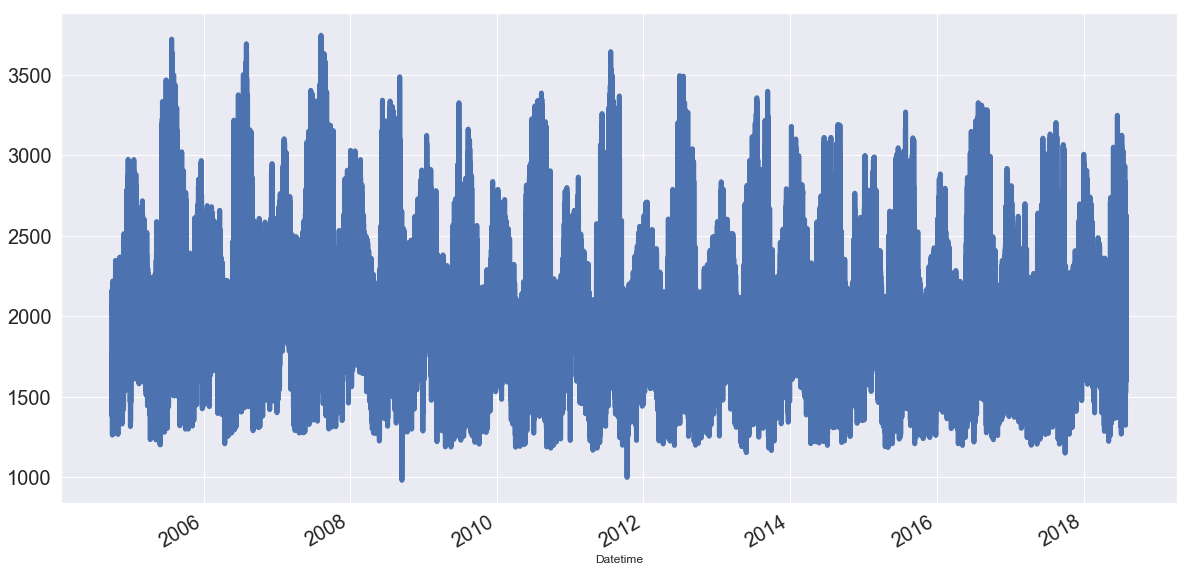

In [30]:
df["DAYTON_MW"].plot(figsize=(20,10), linewidth=5, fontsize=20);

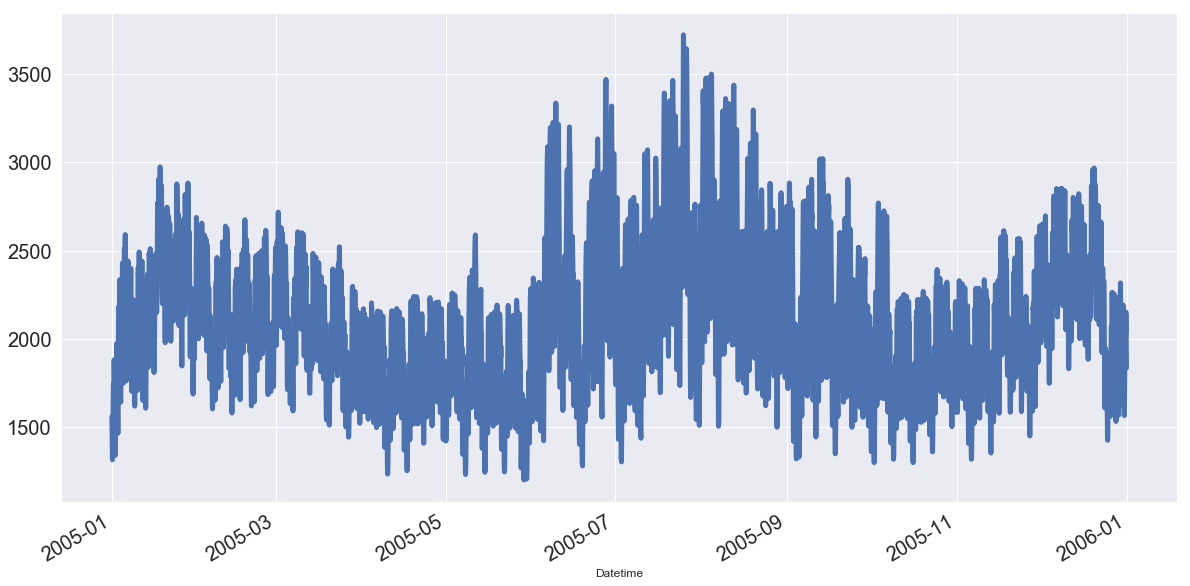

In [31]:
df["DAYTON_MW"][df.index.year == 2005].plot(figsize=(20,10), linewidth=5, fontsize=20);

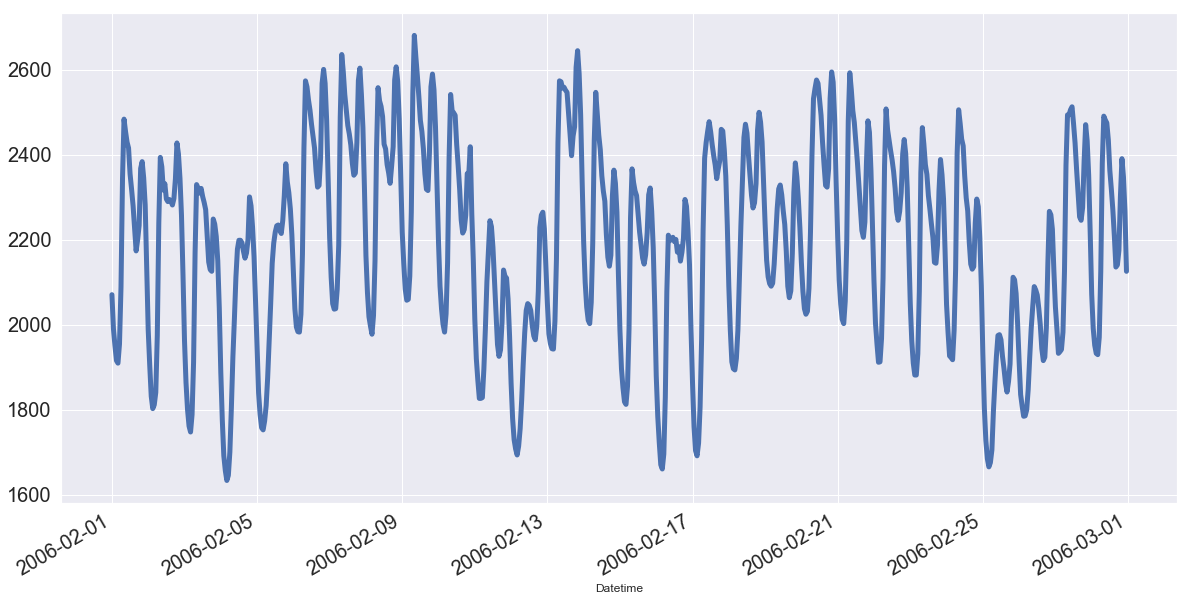

In [32]:
df["DAYTON_MW"][((df.index.year == 2006) & (df.index.month == 2))].plot(figsize=(20,10), linewidth=5, fontsize=20);

In [33]:
## We can see both seasonality and Trend.

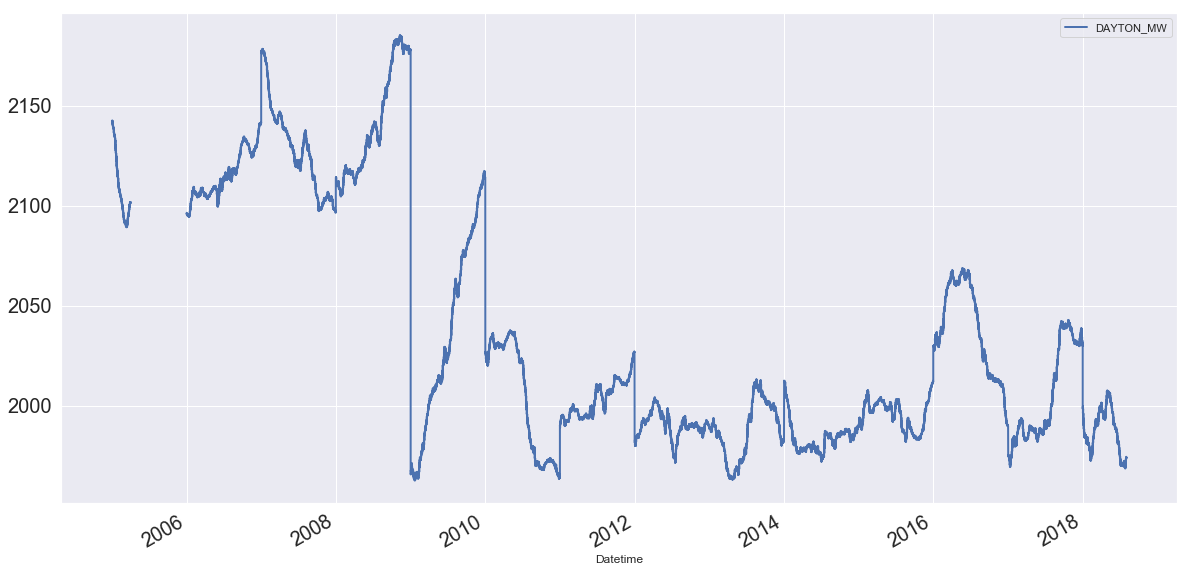

In [34]:
df[["DAYTON_MW"]].rolling(8760).mean().plot(figsize=(20,10), linewidth=2, fontsize=20);

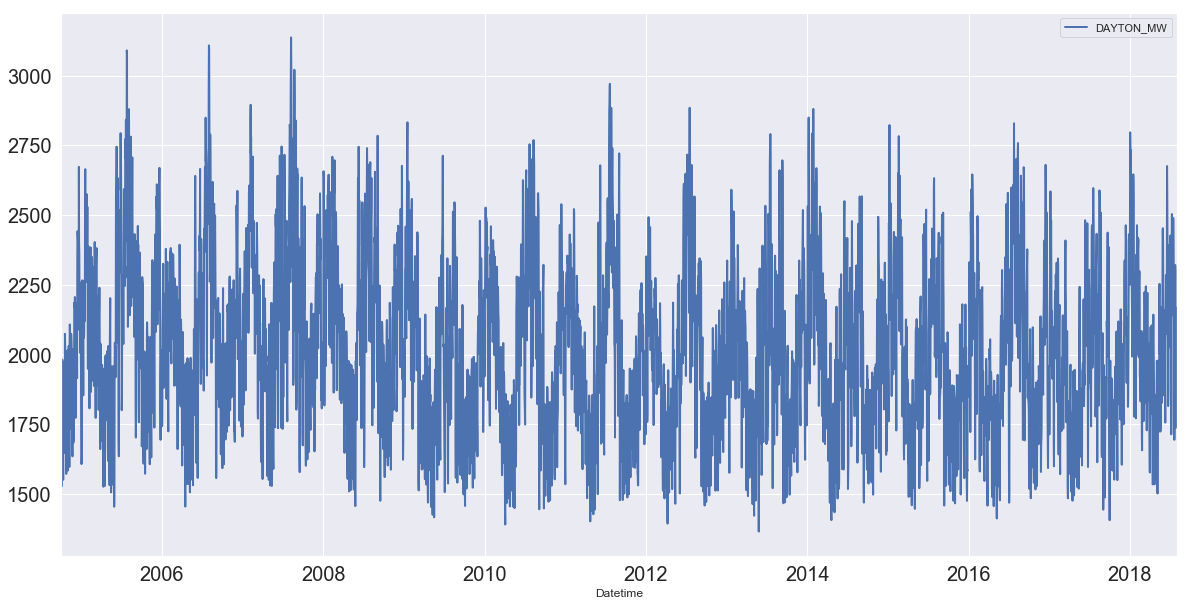

In [35]:
df.resample('D').mean().plot(figsize=(20,10), linewidth=2, fontsize=20);

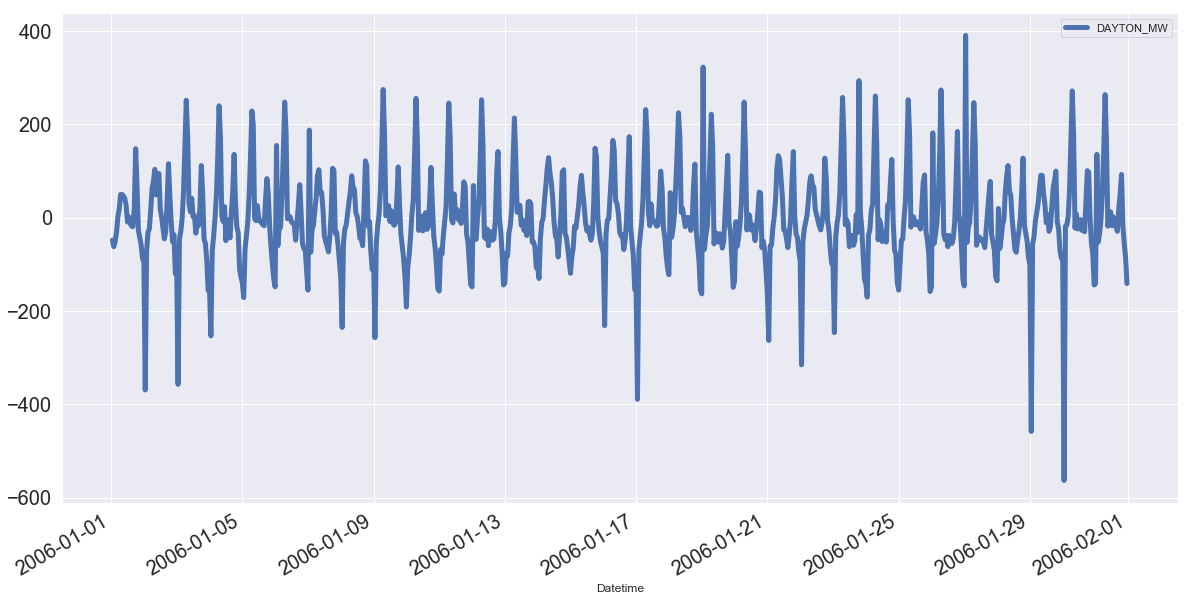

In [36]:
df[((df.index.year == 2006) & (df.index.month == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20);

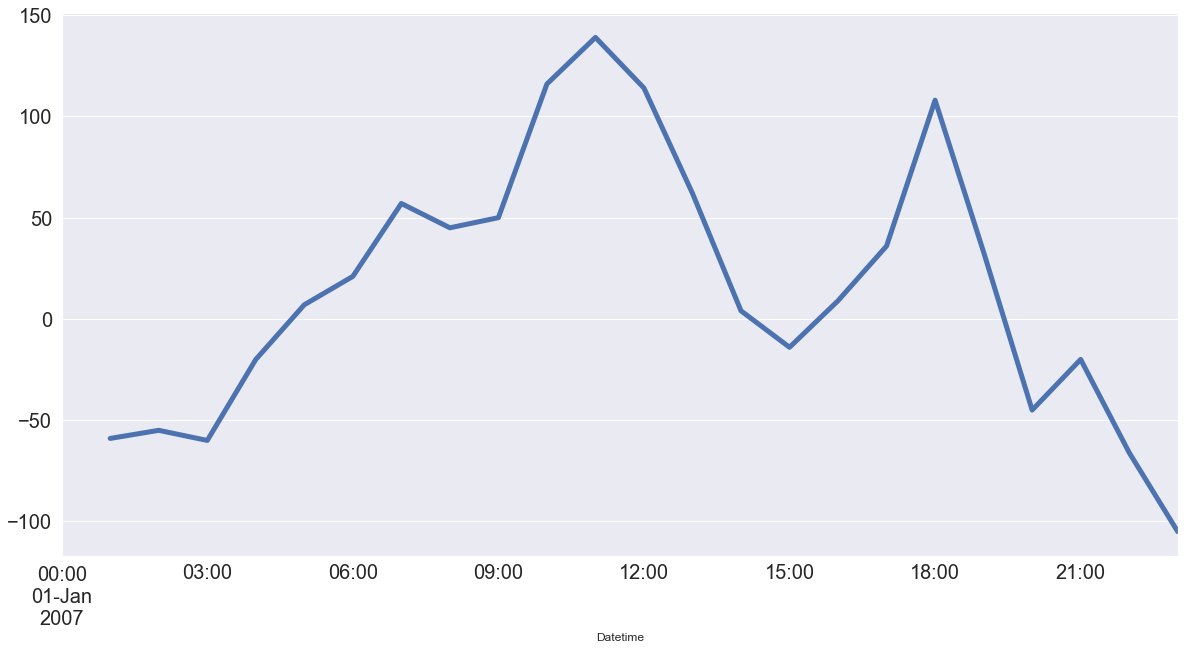

In [37]:
df["DAYTON_MW"][((df.index.year == 2007) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20);

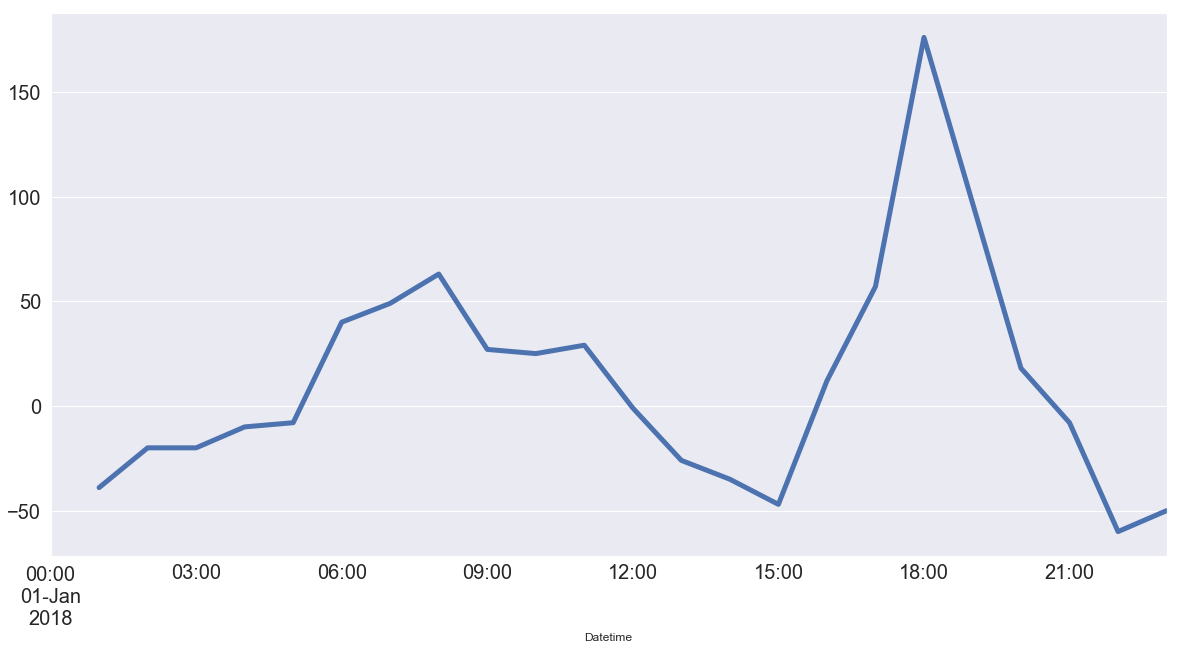

In [38]:
df["DAYTON_MW"][((df.index.year == 2018) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20);

# Preprocess dataset

In [39]:
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


In [40]:
# original data
df_ts = TimeSeries(df["DAYTON_MW"])
df_ts.data

Datetime
2004-12-31 01:00:00    1596.0
2004-12-31 02:00:00    1517.0
2004-12-31 03:00:00    1486.0
2004-12-31 04:00:00    1469.0
2004-12-31 05:00:00    1472.0
                        ...  
2018-01-01 20:00:00    2732.0
2018-01-01 21:00:00    2724.0
2018-01-01 22:00:00    2664.0
2018-01-01 23:00:00    2614.0
2018-01-02 00:00:00    2552.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [41]:
# window_data
df_ts.window_data(24)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan, 1596.],
       [  nan,   nan,   nan, ...,   nan, 1596., 1517.],
       ...,
       [2865., 2771., 2674., ..., 2714., 2732., 2724.],
       [2771., 2674., 2306., ..., 2732., 2724., 2664.],
       [2674., 2306., 2286., ..., 2724., 2664., 2614.]])

In [42]:
# window_stats
df_ts.window_stat(24, "mean")

array([          nan,           nan,           nan, ..., 2474.75      ,
       2466.375     , 2459.83333333])

In [43]:
# difference
df_ts.difference(10)

Datetime
2004-12-31 01:00:00      NaN
2004-12-31 02:00:00      NaN
2004-12-31 03:00:00      NaN
2004-12-31 04:00:00      NaN
2004-12-31 05:00:00      NaN
                       ...  
2018-01-01 20:00:00    280.0
2018-01-01 21:00:00    243.0
2018-01-01 22:00:00    184.0
2018-01-01 23:00:00    160.0
2018-01-02 00:00:00    133.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [44]:
# momentum
df_ts.momentum(10)

Datetime
2004-12-31 01:00:00      NaN
2004-12-31 02:00:00      NaN
2004-12-31 03:00:00      NaN
2004-12-31 04:00:00      NaN
2004-12-31 05:00:00      NaN
                       ...  
2018-01-01 20:00:00    502.0
2018-01-01 21:00:00     68.0
2018-01-01 22:00:00    -10.0
2018-01-01 23:00:00    -28.0
2018-01-02 00:00:00    -30.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [45]:
# force
df_ts.force(10)

Datetime
2004-12-31 01:00:00      NaN
2004-12-31 02:00:00      NaN
2004-12-31 03:00:00      NaN
2004-12-31 04:00:00      NaN
2004-12-31 05:00:00      NaN
                       ...  
2018-01-01 20:00:00    544.0
2018-01-01 21:00:00   -589.0
2018-01-01 22:00:00   -651.0
2018-01-01 23:00:00   -692.0
2018-01-02 00:00:00   -817.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [46]:
# difference_comb
df_ts.difference_comb(24, 10, cutt=True)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [-344., -222.,  175., ...,  280.,  243.,  184.],
       [-222.,  175.,  194., ...,  243.,  184.,  160.],
       [ 175.,  194.,  188., ...,  184.,  160.,  133.]])

In [47]:
# momentum_comb
df_ts.difference_comb(24, 10, cutt=True)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [-344., -222.,  175., ...,  280.,  243.,  184.],
       [-222.,  175.,  194., ...,  243.,  184.,  160.],
       [ 175.,  194.,  188., ...,  184.,  160.,  133.]])

In [48]:
# force_comb
df_ts.difference_comb(24, 10, cutt=True)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [-344., -222.,  175., ...,  280.,  243.,  184.],
       [-222.,  175.,  194., ...,  243.,  184.,  160.],
       [ 175.,  194.,  188., ...,  184.,  160.,  133.]])

In [49]:
# difference_comb
df_ts.difference_comb(24, 10, cutt=True)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [-344., -222.,  175., ...,  280.,  243.,  184.],
       [-222.,  175.,  194., ...,  243.,  184.,  160.],
       [ 175.,  194.,  188., ...,  184.,  160.,  133.]])

In [52]:
# combined_df
# TODO: create method for user to request it easily

combined_df = np.hstack((
    df_ts.window_data(24), # Windowed Data - 24
    np.expand_dims(df_ts.window_stat(24, "mean"), axis = 1),  # Windowed Data MEAN - 1
    df_ts.difference_comb(24, 10, cutt=True), #  Windowed Data DIFF  - 25 - 10 = 14
    np.expand_dims(df["DAYTON_MW"], axis=1), # T + 0 - 1 
    np.expand_dims(df["DAYTON_MW"].shift(-18), axis=1))) # T + 18 Target - 1
combined_df = cut_final(pd.DataFrame(combined_df))
     
print('shape: ', combined_df.shape) # 24 + 14 + 1 + 1 + 1 = 41
combined_df

shape:  (121233, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
24,1596.0,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,...,254.0,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,1713.0,2167.0
25,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,...,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,1647.0,2110.0
26,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,...,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,1611.0,2062.0
27,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,...,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,1608.0,1980.0
28,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,...,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,-338.0,1630.0,1861.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121252,2499.0,2503.0,2526.0,2581.0,2702.0,2868.0,2980.0,3007.0,2999.0,3000.0,...,-36.0,-28.0,-68.0,-97.0,-143.0,-180.0,-482.0,-447.0,2286.0,2732.0
121253,2503.0,2526.0,2581.0,2702.0,2868.0,2980.0,3007.0,2999.0,3000.0,2962.0,...,-28.0,-68.0,-97.0,-143.0,-180.0,-482.0,-447.0,-476.0,2266.0,2724.0
121254,2526.0,2581.0,2702.0,2868.0,2980.0,3007.0,2999.0,3000.0,2962.0,2914.0,...,-68.0,-97.0,-143.0,-180.0,-482.0,-447.0,-476.0,-624.0,2256.0,2664.0
121255,2581.0,2702.0,2868.0,2980.0,3007.0,2999.0,3000.0,2962.0,2914.0,2854.0,...,-97.0,-143.0,-180.0,-482.0,-447.0,-476.0,-624.0,-723.0,2248.0,2614.0


# Training

In [53]:
train_size = int(combined_df.shape[0] * 0.8)

x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [54]:
x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [55]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective="reg:squarederror",
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [56]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [57]:
pred = model.predict(x_test)

In [58]:
mean_squared_error(y_train, model.predict(x_train))

39158.07641171654

In [59]:
mean_squared_error(y_test, model.predict(x_test))

39849.558190840275

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

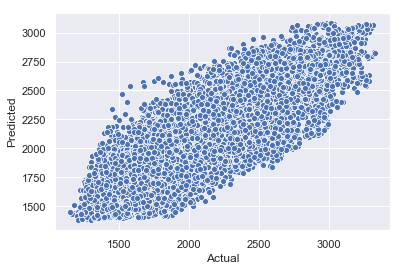

In [60]:
ax = sns.scatterplot(y_test, pred)
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

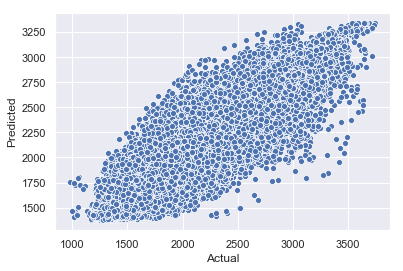

In [61]:
ax = sns.scatterplot(y_train, model.predict(x_train))
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'Time')]

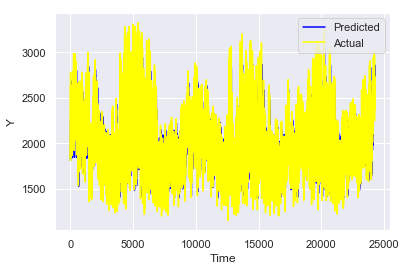

In [62]:
ax = sns.lineplot(range(x_test.shape[0]), model.predict(x_test), 
                  color="blue", label="Predicted", linestyle="-")
ax = sns.lineplot(range(x_test.shape[0]), y_test, 
                  color="yellow", label="Actual", linestyle="-")

ax.set(xlabel='Time', ylabel='Y')

In [63]:
lags = []
for c in range(-30, 30):
    lagged = pd.Series(pred).shift(c)
    lags.append(scipy.stats.spearmanr(lagged, y_test, nan_policy='omit')[0])

In [64]:
### Function definition of code above. Help check autocorrelation between 
## predicted and actual

def get_lag_corr(pred, actual, num_lags):
    lags = []
    for c in range(num_lags):
        lagged = pd.Series(pred).shift(c)
        lags.append(scipy.stats.spearmanr(lagged, actual, nan_policy='omit')[0])
        
    return(lags)

[Text(0, 0.5, 'Corr Coefficient'), Text(0.5, 0, 'Lag')]

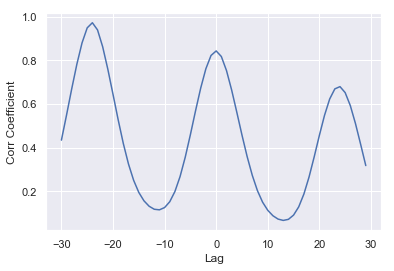

In [65]:
ax = sns.lineplot(range(-len(lags) // 2, len(lags) // 2), lags, linestyle="-")
ax.set(xlabel='Lag', ylabel='Corr Coefficient')

In [66]:
### Next Steps

## Implement difference network
## Use with Neural Networks

In [67]:
### Implement Difference Network
## By subtracting T+0 from T+18
combined_df_difference = combined_df.copy()
combined_df_difference["Diff_y"] = combined_df_difference.iloc[:, -1] - combined_df_difference.iloc[:, -2]

In [68]:
combined_df_difference.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Diff_y
24,1596.0,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,...,220.0,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,1713.0,2167.0,454.0
25,1517.0,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,...,42.0,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,1647.0,2110.0,463.0
26,1486.0,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,...,-95.0,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,1611.0,2062.0,451.0
27,1469.0,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,...,-180.0,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,1608.0,1980.0,372.0
28,1472.0,1518.0,1598.0,1691.0,1748.0,1825.0,1880.0,1891.0,1874.0,1859.0,...,-235.0,-299.0,-116.0,-160.0,-227.0,-337.0,-338.0,1630.0,1861.0,231.0


In [69]:
combined_df_difference["Diff_y"][:5]

24    454.0
25    463.0
26    451.0
27    372.0
28    231.0
Name: Diff_y, dtype: float64

In [70]:
train_size = int(combined_df_difference.shape[0] * 0.8)
x_train, y_train = combined_df_difference.iloc[:train_size, :-3], combined_df_difference["Diff_y"][:train_size]
x_test, y_test = combined_df_difference.iloc[train_size:, :-3], combined_df_difference["Diff_y"][train_size:]

In [71]:
## Collect T+0
tzero_train = combined_df_difference.iloc[:train_size, -3]
tzero_test = combined_df_difference.iloc[train_size:, -3]

In [72]:
model_diff = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective="reg:squarederror",
                 max_depth=3,
                 n_estimators=100,                                                                    
                 seed=42) 

In [73]:
model_diff.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

In [74]:
pred = model_diff.predict(x_test)
pred = pred + tzero_test

In [75]:
mean_squared_error(y_train, model_diff.predict(x_train))

42727.37443000022

In [76]:
mean_squared_error(y_test + tzero_test, pred)

45348.87486530469

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

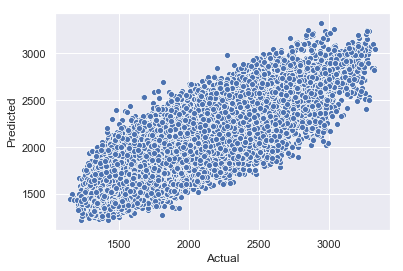

In [77]:
ax = sns.scatterplot(y_test + tzero_test, pred)
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

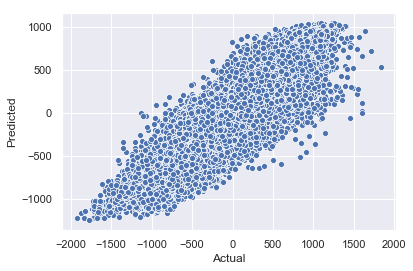

In [79]:
ax = sns.scatterplot(y_train, model_diff.predict(x_train))
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'Time')]

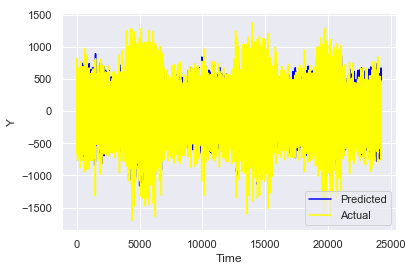

In [80]:
ax = sns.lineplot(range(x_test.shape[0]), model_diff.predict(x_test), 
                  color="blue", label="Predicted", linestyle="-")
ax = sns.lineplot(range(x_test.shape[0]), y_test, 
                  color="yellow", label="Actual", linestyle="-")

ax.set(xlabel='Time', ylabel='Y')

In [81]:
lags = []
for c in range(-30, 30):
    lagged = pd.Series(pred).shift(c)
    lags.append(scipy.stats.spearmanr(lagged, y_test+tzero_test, nan_policy='omit')[0])

[Text(0, 0.5, 'Corr Coefficient'), Text(0.5, 0, 'Lag')]

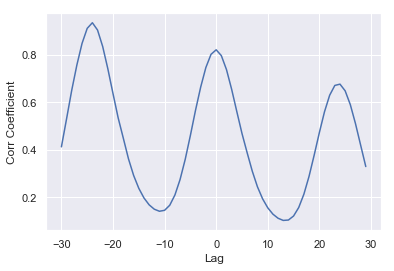

In [82]:
ax = sns.lineplot(range(-len(lags) // 2, len(lags) // 2), lags, linestyle="-")
ax.set(xlabel='Lag', ylabel='Corr Coefficient')

In [83]:
## Lag Measure

# z(delta) =  (y(t+delta) * y_hat(t)) / sig(y)*sig(y_hat)
# kendalltau spearmanr pearsonr